In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 1. Load your data
df = pd.read_csv('train.csv')

# 2. Separate features and targets
feature_columns = [col for col in df.columns if not col.startswith('Blend')]
target_columns = [col for col in df.columns if col.startswith('Blend')]

X = df[feature_columns]
y = df[target_columns]

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost for each blend property
models = {}
for target_col in target_columns:
    # Initialize XGBoost regressor
    model = XGBRegressor(
        n_estimators=100,      # Number of trees
        learning_rate=0.1,     # Learning rate
        max_depth=6,           # Max tree depth
        random_state=42,
        n_jobs=-1              # Use all CPU cores
    )
    
    # Train the model
    model.fit(X_train, y_train[target_col])
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test[target_col], y_pred))
    r2 = r2_score(y_test[target_col], y_pred)
    
    print(f"{target_col}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    
    models[target_col] = model

BlendProperty1: RMSE = 0.2716, R² = 0.9198
BlendProperty2: RMSE = 0.2536, R² = 0.9301
BlendProperty3: RMSE = 0.2191, R² = 0.9499
BlendProperty4: RMSE = 0.2842, R² = 0.9180
BlendProperty5: RMSE = 0.1035, R² = 0.9900
BlendProperty6: RMSE = 0.2739, R² = 0.9240
BlendProperty7: RMSE = 0.2216, R² = 0.9488
BlendProperty8: RMSE = 0.3124, R² = 0.8987
BlendProperty9: RMSE = 0.3148, R² = 0.9059
BlendProperty10: RMSE = 0.2547, R² = 0.9366


In [3]:
XGBRegressor(
    n_estimators=100,        # Number of boosting rounds
    learning_rate=0.1,       # Step size shrinkage (0.01-0.3)
    max_depth=6,             # Max tree depth (3-10)
    min_child_weight=1,      # Min sum of instance weight in child
    subsample=0.8,           # Fraction of samples used for training trees
    colsample_bytree=0.8,    # Fraction of features used for training trees
    reg_alpha=0,             # L1 regularization
    reg_lambda=1,            # L2 regularization
    random_state=42,
    n_jobs=-1
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [4]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train[target_col], 
                          cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print(f"CV RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

CV RMSE: 0.2448 (+/- 0.0317)


In [5]:
# Get feature importance
importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 10 features:")
print(feature_importance_df.head(10))

Top 10 features:
                  feature  importance
3     Component4_fraction    0.426178
4     Component5_fraction    0.179514
1     Component2_fraction    0.098374
52  Component3_Property10    0.049931
50  Component1_Property10    0.018546
2     Component3_fraction    0.017224
53  Component4_Property10    0.014713
51  Component2_Property10    0.013142
0     Component1_fraction    0.009688
45   Component1_Property9    0.007607


In [6]:
# Predict on new data
new_data = X_test  # Your new data here
predictions = {}
for target_col in target_columns:
    predictions[target_col] = models[target_col].predict(new_data)

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions)

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming you have:
# predictions_df - your predictions DataFrame
# y_test - your true targets DataFrame

def evaluate_predictions(predictions_df, y_test):
    """
    Evaluate predictions against true targets for all blend properties
    """
    results = {}
    
    for target_col in y_test.columns:
        if target_col in predictions_df.columns:
            y_true = y_test[target_col]
            y_pred = predictions_df[target_col]
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            
            # Store results
            results[target_col] = {
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2
            }
            
            print(f"{target_col}:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")
            print()
    
    # Calculate average metrics
    avg_rmse = np.mean([results[col]['RMSE'] for col in results])
    avg_mae = np.mean([results[col]['MAE'] for col in results])
    avg_r2 = np.mean([results[col]['R²'] for col in results])
    
    print("="*50)
    print("AVERAGE PERFORMANCE:")
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average MAE:  {avg_mae:.4f}")
    print(f"Average R²:   {avg_r2:.4f}")
    
    return results

# Usage example:
# results = evaluate_predictions(predictions_df, y_test)

In [8]:
results=evaluate_predictions(predictions_df,y_test)

BlendProperty1:
  RMSE: 0.2716
  MAE:  0.2053
  R²:   0.9198

BlendProperty2:
  RMSE: 0.2536
  MAE:  0.1962
  R²:   0.9301

BlendProperty3:
  RMSE: 0.2191
  MAE:  0.1643
  R²:   0.9499

BlendProperty4:
  RMSE: 0.2842
  MAE:  0.2142
  R²:   0.9180

BlendProperty5:
  RMSE: 0.1035
  MAE:  0.0263
  R²:   0.9900

BlendProperty6:
  RMSE: 0.2739
  MAE:  0.2072
  R²:   0.9240

BlendProperty7:
  RMSE: 0.2216
  MAE:  0.1674
  R²:   0.9488

BlendProperty8:
  RMSE: 0.3124
  MAE:  0.2407
  R²:   0.8987

BlendProperty9:
  RMSE: 0.3148
  MAE:  0.2374
  R²:   0.9059

BlendProperty10:
  RMSE: 0.2547
  MAE:  0.1890
  R²:   0.9366

AVERAGE PERFORMANCE:
Average RMSE: 0.2509
Average MAE:  0.1848
Average R²:   0.9322


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def plot_predictions_vs_test(predictions_df, y_test):
    """
    Plot predictions vs actual test values for each blending property
    """
    target_columns = y_test.columns
    n_targets = len(target_columns)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_targets > 1 else [axes]
    
    for i, target_col in enumerate(target_columns):
        if target_col in predictions_df.columns:
            # Get actual and predicted values
            y_actual = y_test[target_col]
            y_pred = predictions_df[target_col]
            
            # Create scatter plot
            axes[i].scatter(y_actual, y_pred, alpha=0.6, s=20)
            
            # Add perfect prediction line
            min_val = min(y_actual.min(), y_pred.min())
            max_val = max(y_actual.max(), y_pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            r2 = r2_score(y_actual, y_pred)
            mae = mean_absolute_error(y_actual, y_pred)
            
            # Add metrics to plot
            axes[i].text(0.05, 0.95, f'RMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAE: {mae:.4f}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # Labels and title
            axes[i].set_xlabel('Actual Values')
            axes[i].set_ylabel('Predicted Values')
            axes[i].set_title(f'{target_col}')
            axes[i].grid(True, alpha=0.3)
            axes[i].legend()
    
    # Hide unused subplots
    for i in range(n_targets, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Predictions vs Actual Test Values for All Blend Properties', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print summary metrics
    print("TEST SET PERFORMANCE SUMMARY:")
    print("="*60)
    for target_col in target_columns:
        if target_col in predictions_df.columns:
            y_actual = y_test[target_col]
            y_pred = predictions_df[target_col]
            rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            r2 = r2_score(y_actual, y_pred)
            mae = mean_absolute_error(y_actual, y_pred)
            print(f"{target_col:15} | RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# Usage:


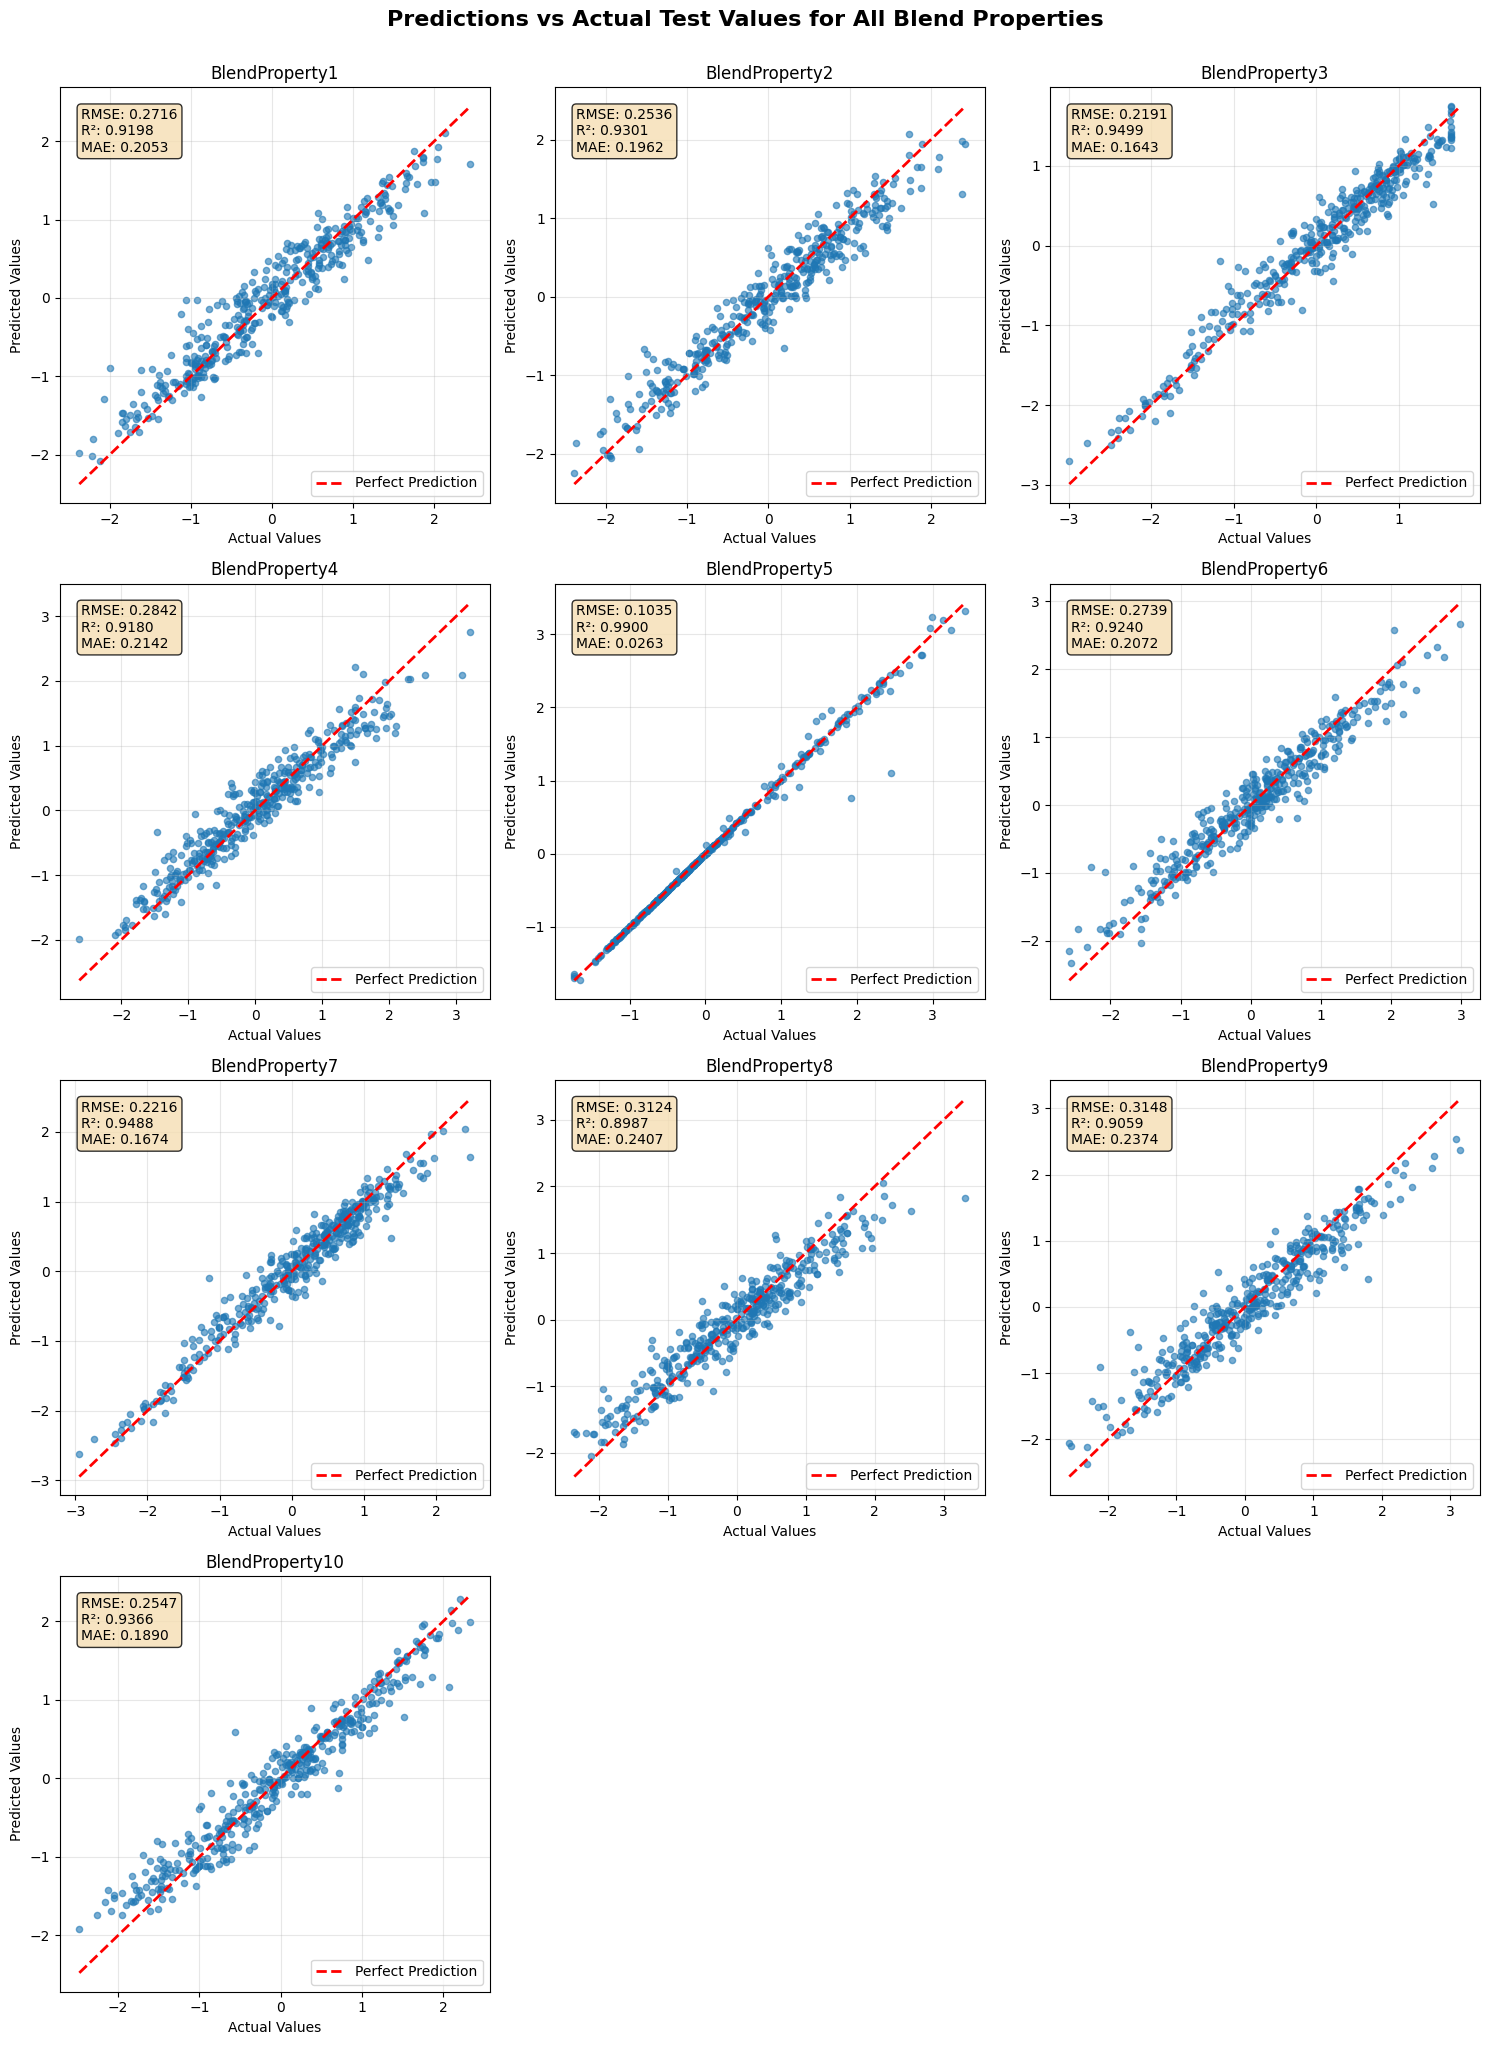

TEST SET PERFORMANCE SUMMARY:
BlendProperty1  | RMSE: 0.2716 | R²: 0.9198 | MAE: 0.2053
BlendProperty2  | RMSE: 0.2536 | R²: 0.9301 | MAE: 0.1962
BlendProperty3  | RMSE: 0.2191 | R²: 0.9499 | MAE: 0.1643
BlendProperty4  | RMSE: 0.2842 | R²: 0.9180 | MAE: 0.2142
BlendProperty5  | RMSE: 0.1035 | R²: 0.9900 | MAE: 0.0263
BlendProperty6  | RMSE: 0.2739 | R²: 0.9240 | MAE: 0.2072
BlendProperty7  | RMSE: 0.2216 | R²: 0.9488 | MAE: 0.1674
BlendProperty8  | RMSE: 0.3124 | R²: 0.8987 | MAE: 0.2407
BlendProperty9  | RMSE: 0.3148 | R²: 0.9059 | MAE: 0.2374
BlendProperty10 | RMSE: 0.2547 | R²: 0.9366 | MAE: 0.1890


In [10]:
plot_predictions_vs_test(predictions_df, y_test)